In [146]:
from mplfinance.original_flavor import candlestick_ohlc
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

In [179]:
# Đọc dữ liệu từ file CSV
data_path = 'vn-index.csv'  # Thay đổi đường dẫn theo vị trí file dữ liệu của bạn
vnindex_data = pd.read_csv(data_path)
vnindex_data['Date'] = pd.to_datetime(vnindex_data['Date'], dayfirst=True)
# vnindex_data.set_index('Date', inplace=True)

# Loại bỏ dấu phẩy và chuyển đổi số liệu trong các cột số
vnindex_data['Open'] = vnindex_data['Open'].str.replace(',', '').astype(float)
vnindex_data['High'] = vnindex_data['High'].str.replace(',', '').astype(float)
vnindex_data['Low'] = vnindex_data['Low'].str.replace(',', '').astype(float)
vnindex_data['Close'] = vnindex_data['Close'].str.replace(',', '').astype(float)


# Loại bỏ 'K' và chuyển đổi giá trị sang số thực, nhân với 1000 nếu cần
vnindex_data['Volume'] = vnindex_data['Volume'].replace({'K': '*1e3', 'M': '*1e6'}, regex=True).map(pd.eval).astype(float)
vnindex_data.dropna(inplace=True)

In [192]:
# date from 3/5/2024 to 6/5/2019
end = '17/12/2024'
start = '06/03/2021'

In [193]:
# Chuyển đổi ngày bắt đầu và kết thúc từ chuỗi thành datetime
start_date = pd.to_datetime(start, dayfirst=True)
end_date = pd.to_datetime(end, dayfirst=True)
filtered_data = vnindex_data[(vnindex_data['Date'] >= start_date) & (vnindex_data['Date'] <= end_date)]

In [194]:
# chuyển dữ liệu về khung tuần
weekly_data = filtered_data.set_index('Date').resample('W').agg({
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last'
    })
weekly_data.dropna(inplace=True)
weekly_data.reset_index(inplace=True)

weekly_data['bottom'] = False
weekly_data['top'] = False


In [195]:
# Logic phát hiện đáy theo quy tắc mới
for i in range(1, len(weekly_data) - 2):
    # Kiểm tra nếu cây nến hiện tại có giá low thấp nhất
    if weekly_data.iloc[i]['Low'] < weekly_data.iloc[i-1]['Low'] and weekly_data.iloc[i]['Low'] < weekly_data.iloc[i+1]['Low'] and weekly_data.iloc[i+2]['Low'] > weekly_data.iloc[i+1]['Low']:
        # Tìm cây nến tiếp theo có giá close cao hơn giá high của cây nến low
        for j in range(i + 1, len(weekly_data)):
            if weekly_data.iloc[j]['Close'] > weekly_data.iloc[i]['High']:
                weekly_data.at[weekly_data.index[i], 'bottom'] = True
                break
            
# Logic phát hiện đỉnh theo quy tắc mới
for i in range(1, len(weekly_data) - 2):
    if weekly_data.iloc[i]['High'] > weekly_data.iloc[i-1]['High'] and weekly_data.iloc[i]['High'] > weekly_data.iloc[i+1]['High'] and weekly_data.iloc[i+2]['High'] < weekly_data.iloc[i+1]['High']:
        for j in range(i + 1, len(weekly_data)):
            if weekly_data.iloc[j]['Close'] < weekly_data.iloc[i]['Low']:
                weekly_data.at[weekly_data.index[i], 'top'] = True
                break       

In [196]:
# Logic phát hiện đáy theo quy tắc mới
for i in range(1, len(weekly_data) - 2):
    # Kiểm tra nếu cây nến hiện tại có giá low thấp nhất và giá low của cây nến tiếp theo thấp hơn cây nến hiện tại
    if (weekly_data.iloc[i]['Low'] < weekly_data.iloc[i-1]['Low'] and weekly_data.iloc[i]['Low'] < weekly_data.iloc[i+1]['Low'] and weekly_data.iloc[i+2]['Low'] > weekly_data.iloc[i+1]['Low']):
        
        # Hoặc nếu có hai cây nến xanh liên tiếp sau cây nến đỏ thấp nhất
        if (weekly_data.iloc[i+1]['Open'] < weekly_data.iloc[i+1]['Close'] and  # Green candle
            weekly_data.iloc[i+2]['Open'] < weekly_data.iloc[i+2]['Close']):  # Another green candle
            weekly_data.at[weekly_data.index[i], 'bottom'] = True

# Logic phát hiện đỉnh theo quy tắc ngược lại
for i in range(1, len(weekly_data) - 2):
    # Kiểm tra nếu cây nến hiện tại có giá high cao nhất và giá high của cây nến tiếp theo cao hơn cây nến hiện tại
    if (weekly_data.iloc[i]['High'] > weekly_data.iloc[i-1]['High'] and weekly_data.iloc[i]['High'] > weekly_data.iloc[i+1]['High'] and weekly_data.iloc[i+2]['High'] < weekly_data.iloc[i+1]['High']):
        
        # Hoặc nếu có hai cây nến đỏ liên tiếp sau cây nến xanh cao nhất
        if (weekly_data.iloc[i+1]['Open'] > weekly_data.iloc[i+1]['Close'] and  # Red candle
            weekly_data.iloc[i+2]['Open'] > weekly_data.iloc[i+2]['Close']):  # Another red candle
            weekly_data.at[weekly_data.index[i], 'top'] = True

In [197]:
chart = weekly_data
chart['Date'] = chart['Date'].apply(mdates.date2num)

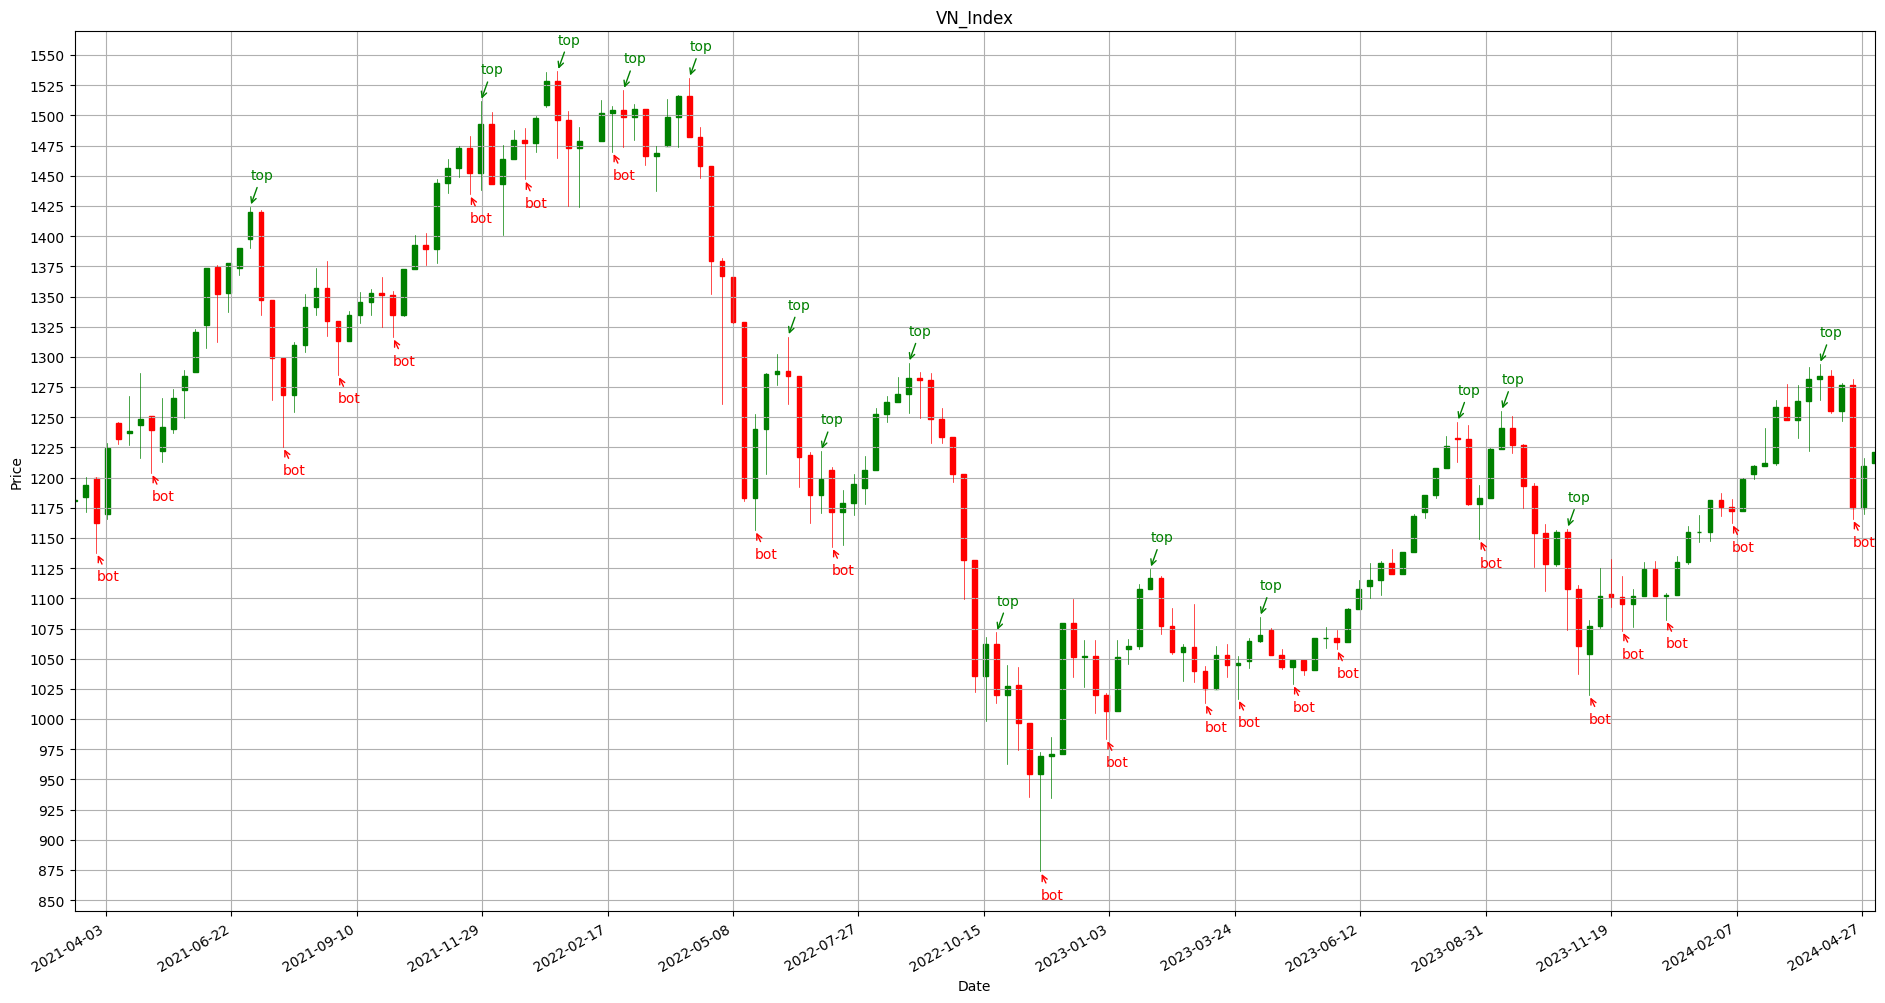

In [199]:
# Vẽ đồ thị nến
fig, ax = plt.subplots(figsize=(20, 8))

candlestick_ohlc(ax, chart[['Date', 'Open', 'High', 'Low', 'Close']].values, width=3, colorup='g', colordown='r', alpha=1)

# Đánh dấu đỉnh và đáy
for idx, row in chart.iterrows():
    if row['bottom']:
        ax.annotate('bot', (row['Date'], row['Low']), xytext=(0, -20), 
                    textcoords='offset points', arrowprops=dict(arrowstyle='->', color='red'), color='red')
    if row['top']:
        ax.annotate('top', (row['Date'], row['High']), xytext=(0, 20), 
                    textcoords='offset points', arrowprops=dict(arrowstyle='->', color='green'), color='green')

# Cấu hình trục x
ax.xaxis.set_major_locator(ticker.MaxNLocator(15))
ax.yaxis.set_major_locator(ticker.MaxNLocator(35))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))


# Điều chỉnh giới hạn của trục x để loại bỏ khoảng trắng
ax.set_xlim([weekly_data['Date'].min(), weekly_data['Date'].max()])

fig.autofmt_xdate()
plt.title('VN_Index')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)


# Loại bỏ khoảng trắng dư thừa
plt.subplots_adjust(left=0.05, right=0.95, top=1.25, bottom=0.15)

plt.show()
